In [1]:
import sys
import numpy as np
import torch
import math
%matplotlib inline
import matplotlib.pyplot as plt
from tnn_util import *

torch.manual_seed(1) # Fix seed of the random number generators
np.random.seed(1)

In [2]:
def show_imgs(imgs,l1=4,l2=5,s1=6,s2=6):
    """    Plot images    """
    plt.rcParams['figure.figsize']=(s1,s2)
    imgs=imgs.reshape([-1,28,28])
    g, ax = plt.subplots(l1,l2)
    for i in range(l1):
        for j in range(l2):
            a=i*l1+j
            if(a>=imgs.shape[0]):
                break
            ax[i][j].imshow(imgs[a,:,:],cmap='summer')
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
    plt.show()

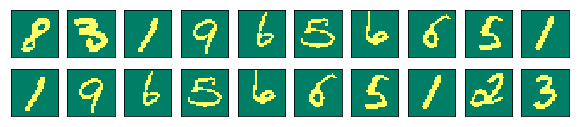

In [3]:
n = 784
m = 20
data = np.load("imgs/mnist_100_28x28_p0.5.npy")
data = data[:m, :, :]
data = torch.LongTensor(data)
data = data.view(-1, 784)
show_imgs(data, 2, 10, 10, 2)

## 1 - Building blocks of the Model

## 1.1 - Forward
\begin{align*}
&f^{l}(x) = \frac{1}{m}\sum_{i}{[A^{s_{1}}_{\alpha_{0}\alpha_{1}}\cdots A^{s_{n}}_{\alpha_{n-1}\alpha_{n}}\Phi^{s_{1}s_{2}\cdots s_{n}}(x^{i})]}\\
&L = \frac{1}{m}\sum_{i}{[f^{l}(x_{i}) - \delta^{l}_{n}]^{2}}
\end{align*}

In [6]:
def tnn_cell_forward_right(X, Y, parameters):
    m, n = X.shape
    tensors, l = parameters['tensors'], parameters['l']
    psi = torch.ones([m, 1, 1])
    assert l < n-1, "invalid l!"
    for site in range(l):
        psi = psi @ tensors[site][:, X[:, site], :].permute(1, 0, 2)
    left_psi = psi
    psi = psi @ tensors[l][:, X[:, l], :, :].permute(2, 1, 0, 3) @ tensors[l+1][:, X[:, l+1], :].permute(1, 0, 2)
    if l == n - 2:
        right_psi = torch.ones([m, 1, 1])
    else:
        right_psi = torch.ones([m, tensors[l+1].shape[2], tensors[l+1].shape[2]])
        for site in range(l+2, n):
            psi = psi @ tensors[site][:, X[:, site], :].permute(1, 0, 2)
            right_psi = right_psi @ tensors[site][:, X[:, site], :].permute(1, 0, 2)
    cache = (left_psi, right_psi, psi)
    loss = torch.sum(torch.pow(psi.squeeze()-Y.transpose(0, 1), 2)) / m
    return loss, cache

In [7]:
def tnn_cell_forward_left(X, Y, parameters):
    m, n = X.shape
    tensors, l = parameters['tensors'], parameters['l']
    psi = torch.ones([m, 1, 1])
    assert l > 0, "invalid l!"
    for site in range(l-1):
        psi = psi @ tensors[site][:, X[:, site], :].permute(1, 0, 2)
    left_psi = psi
    psi = psi @ tensors[l-1][:, X[:, l-1], :].permute(1, 0, 2) @ tensors[l][:, X[:, l], :, :].permute(2, 1, 0, 3)
    if l == n - 1:
        right_psi = torch.ones([m, 1, 1])
    else:
        right_psi = torch.ones([m, tensors[l].shape[3], tensors[l].shape[3]])
        for site in range(l+1, n):
            psi = psi @ tensors[site][:, X[:, site], :].permute(1, 0, 2)
            right_psi = right_psi @ tensors[site][:, X[:, site], :].permute(1, 0, 2)
    cache = (left_psi, right_psi, psi)
    loss = torch.sum(torch.pow(psi.squeeze()-Y.transpose(0, 1), 2)) / m
    return loss, cache

In [8]:
#test for tnn_cell_forward_right() module
X = torch.randint(1, (m, n))
loss, cache = tnn_cell_forward_right(X, Y_onehot, parameters)
(left_psi, right_psi, psi) = cache
print("number of sample in one batch is: ", m)
print("number of features of one sample is: ", n)
print("output shape is: ", psi.shape)
print("shape of left tensor of Al is: ", left_psi.shape)
print("shape of right tensor of Al is: ", right_psi.shape)
print("the loss is: ", loss)

number of sample in one batch is:  5
number of features of one sample is:  10
output shape is:  torch.Size([10, 5, 1, 1])
shape of left tensor of Al is:  torch.Size([5, 1, 5])
shape of right tensor of Al is:  torch.Size([5, 5, 1])
the loss is:  tensor(7315317.)


In [9]:
#test for tnn_cell_forward_left() module
X = torch.randint(1, (m, n))
loss, cache = tnn_cell_forward_left(X, Y_onehot, parameters)
(left_psi, right_psi, psi) = cache
print("number of sample in one batch is: ", m)
print("number of features of one sample is: ", n)
print("output shape is: ", psi.shape)
print("shape of left tensor of Al is: ", left_psi.shape)
print("shape of right tensor of Al is: ", right_psi.shape)
print("the loss is: ", loss)

number of sample in one batch is:  5
number of features of one sample is:  10
output shape is:  torch.Size([10, 5, 1, 1])
shape of left tensor of Al is:  torch.Size([5, 1, 5])
shape of right tensor of Al is:  torch.Size([5, 5, 1])
the loss is:  tensor(7315317.)


## 1.2 - Backward
\begin{align*}
&\frac{\partial{L}}{\partial{f^{l}(x^{(i)})}} = 2(f^{l}(x_{i}) - \delta^{l}_{n})\\
&\frac{\partial{f^{l}(x^{(i)})}}{\partial{B^{l,s_{k}s_{k+1}}_{\alpha_{k-1}\alpha_{k+1}}}} = \tilde{A}^{s_{1}s_{2}\cdots s_{k-1}}_{\alpha_{k-1}}\tilde{B}^{s_{k+2}\cdots s_{n}}_{\alpha_{k+1}}\Phi^{s_{1}s_{2}\cdots s_{n}}(x^{(i)})
\end{align*}

In [10]:
def tnn_cell_backward_right(X, Y, cache, parameters):
    """
    Calculate the gradients of the loss function wrt mps.
    
    Arguments:
    Y -- labels of the samples, pytorch tensor with dimension (m, index)
    
    Return:
    dAl -- gradient of the tensor, pytorch tensor with dimension (m, index, alpha_lf, alpha_rig)
    
    
    """
    left_psi, right_psi, psi = cache
    l =  parameters['l']
    left_index, right_index = left_psi.shape[-1], right_psi.shape[-2]
    m = X.shape[0]
    index = parameters['index']
    dfl = 2 * (psi - Y.reshape_as(psi))
    dBl_m = dfl * (left_psi.transpose(1, 2) @ right_psi.transpose(1, 2))
    index1, index2 = (X[:, l] == 0).view(1, -1, 1, 1), (X[:, l+1] == 0).view(1, -1, 1, 1)
    index3, index4 = 1 - index1, 1 - index2
    dBl_1 = (dBl_m * (index1 * index2).type(torch.float)).mean(1, True)
    dBl_2 = (dBl_m * (index1 * index4).type(torch.float)).mean(1, True)
    dBl_3 = (dBl_m * (index3 * index2).type(torch.float)).mean(1, True)
    dBl_4 = (dBl_m * (index3 * index4).type(torch.float)).mean(1, True)
    dBl = torch.cat((dBl_1, dBl_2, dBl_3, dBl_4), 1).reshape(index, 2, 2, left_index, right_index)
    
    gradients = {'dBl': dBl}
    return gradients

In [142]:
def tnn_cell_backward_left(X, Y, cache, parameters):
    """
    Calculate the gradients of the loss function wrt mps.
    
    Arguments:
    Y -- labels of the samples, pytorch tensor with dimension (m, index)
    
    Return:
    dAl -- gradient of the tensor, pytorch tensor with dimension (m, index, alpha_lf, alpha_rig)
    
    
    """
    left_psi, right_psi, psi = cache
    l =  parameters['l']
    left_index, right_index = left_psi.shape[-1], right_psi.shape[-2]
    m = X.shape[0]
    index = parameters['index']
    dfl = 2 * (psi - Y.reshape_as(psi))
    dBl_m = dfl * (left_psi.transpose(1, 2) @ right_psi.transpose(1, 2))
    index1, index2 = (X[:, l-1] == 0).view(1, -1, 1, 1), (X[:, l] == 0).view(1, -1, 1, 1)
    index3, index4 = 1 - index1, 1 - index2
    dBl_1 = (dBl_m * (index1 * index2).type(torch.float)).mean(1, True)
    dBl_2 = (dBl_m * (index1 * index4).type(torch.float)).mean(1, True)
    dBl_3 = (dBl_m * (index3 * index2).type(torch.float)).mean(1, True)
    dBl_4 = (dBl_m * (index3 * index4).type(torch.float)).mean(1, True)
    dBl = torch.cat((dBl_1, dBl_2, dBl_3, dBl_4), 1).reshape(index, 2, 2, left_index, right_index)
    
    gradients = {'dBl': dBl}
    return gradients

In [12]:
#test for tnn_cell_backward_right()
gradients = tnn_cell_backward_right(X, Y_onehot, cache, parameters)
dBl = gradients['dBl']
print("gradients of tensor Bl: ", dBl.shape)

gradients of tensor Bl:  torch.Size([10, 2, 2, 5, 5])


In [13]:
#test for tnn_cell_backward_left()
gradients = tnn_cell_backward_left(X, Y_onehot, cache, parameters)
dBl = gradients['dBl']
print("gradients of tensor Bl: ", dBl.shape)

gradients of tensor Bl:  torch.Size([10, 2, 2, 5, 5])


In [143]:
torch.manual_seed(1)
m, n, l, index, Dmax = 5, 10, 8, 10, 5
parameters = {'m': m, 'n': n, 'Dmax': Dmax, 'index': 10, 'l': l}
parameters = tensor_initialize(n, Dmax, l, parameters)
loss, cache = tnn_cell_forward_right(X, Y_onehot, parameters)

In [67]:
gradients = tnn_cell_backward_left(X, Y_onehot, cache, parameters)

In [69]:
for i in range(n):
    print(parameters['tensors'][i].shape)

torch.Size([1, 2, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 10, 5])
torch.Size([5, 2, 1])


\begin{align*}
\Delta B^{l,s_{k-1}s_{k}}_{\alpha_{k-1}\alpha_{k+1}}\to
\begin{bmatrix}
B^{l,x_{m}}_{\alpha_{k-1}\alpha_{k+1}}\\
\cdots\\
B^{l,x_{n}}_{\alpha_{k-1}\alpha_{k+1}}
\end{bmatrix}
\end{align*}

In [14]:
def update_parameters_right(X, parameters, gradients, bond, learning_rate):
    
    m, n, index, tensors, l = parameters['m'], parameters['n'], parameters['index'], parameters['tensors'], parameters['l']
    assert l < n, "invalid l"
    dBl = gradients['dBl']
    Bl = tensors[l].permute(2, 1, 0, 3).unsqueeze(2) @ tensors[l+1].permute(1, 0, 2).unsqueeze(0)
    Bl +=  dBl
    alpha_left, alpha_right = dBl.shape[-2], dBl.shape[-1]
    u, s, vt = torch.svd(Bl.permute(1, 3, 0, 2, 4).contiguous().view(2*alpha_left, 2*alpha_right*index))
    tensors[l] = ((u * s).split(bond, 1)[0]).reshape(2, alpha_left, bond).permute(1, 0, 2)
    tensors[l+1] = (((vt.transpose(0, 1)).split(bond, 0))[0]).reshape(bond, index, 2, alpha_right).permute(0, 2, 1, 3)
    parameters['l'] = l + 1      
    
    return parameters  

In [160]:
def update_parameters_left(X, parameters, gradients, bond, learning_rate):
    
    m, n, index, tensors, l = parameters['m'], parameters['n'], parameters['index'], parameters['tensors'], parameters['l']
    assert l > 0, "invalid l"
    dBl = gradients['dBl']
    Bl = tensors[l-1].permute(1, 0, 2).unsqueeze(0) @ tensors[l].permute(2, 1, 0, 3).unsqueeze(2)
    Bl +=  dBl
    alpha_left, alpha_right = dBl.shape[-2], dBl.shape[-1]
    u, s, vt = torch.svd(Bl.permute(1, 3, 0, 2, 4).contiguous().view(2*alpha_left*index, 2*alpha_right))
    tensors[l-1] = ((u * s).split(bond, 1)[0]).reshape(2, alpha_left, index, bond).permute(1, 0, 2, 3)
    tensors[l] = (((vt.transpose(0, 1)).split(bond, 0))[0]).reshape(bond, 2, alpha_right)
    parameters['l'] = l - 1
    
    return parameters  

In [16]:
#test for update_parameters_right()
bond, learning_rate, n = 1, 0.01, parameters['n']
parameters = update_parameters_right(X, parameters, gradients, bond, learning_rate)
tensors = parameters['tensors']
print("updated A^{l} tensor: ", tensors[l].shape)
print("updated A^{l+1} tensor: ", tensors[l+1].shape)
for i in range(n):
    print(tensors[i].shape)

updated A^{l} tensor:  torch.Size([5, 2, 1])
updated A^{l+1} tensor:  torch.Size([1, 2, 10, 5])
torch.Size([1, 2, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 1])
torch.Size([1, 2, 10, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 1])


In [17]:
#test for update_parameters_left()
bond, learning_rate, n = 1, 0.01, parameters['n']
parameters = update_parameters_left(X, parameters, gradients, bond, learning_rate)
tensors = parameters['tensors']
print("updated A^{l} tensor: ", tensors[l].shape)
print("updated A^{l+1} tensor: ", tensors[l+1].shape)
for i in range(n):
    print(tensors[i].shape)

updated A^{l} tensor:  torch.Size([5, 2, 1])
updated A^{l+1} tensor:  torch.Size([5, 2, 10, 1])
torch.Size([1, 2, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 1])
torch.Size([5, 2, 10, 1])
torch.Size([1, 2, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 5])
torch.Size([5, 2, 1])


In [163]:
def optimize(X, Y, parameters, bond, learning_rate=0.01):
    
    n, l, Dmax = parameters['n'], parameters['l'], parameters['Dmax']
    parameters = tensor_initialize(n, Dmax, l, parameters)
    for i in range(l, n-1):
        loss, cache = tnn_cell_forward_right(X, Y, parameters)
        gradients = tnn_cell_backward_right(X, Y, cache, parameters)
        parameters = update_parameters_right(X, parameters, gradients, bond, learning_rate)
    for i in range(n, 1, -1):
        loss, cache = tnn_cell_forward_left(X, Y, parameters)
        gradients = tnn_cell_backward_left(X, Y, cache, parameters)
        parameters = update_parameters_left(X, parameters, gradients, bond, learning_rate)
        
    return parameters, loss, gradients

In [164]:
#test for optimize()
torch.manual_seed(1)
m, n, l, index, Dmax, bond = 5, 10, 8, 10, 5, 1
X = torch.randint(1, (m, n))
Y = np.random.binomial(index, 0.5, m)
Y_onehot = one_hot(Y, index)
parameters = {'m': m, 'n': n, 'Dmax': Dmax, 'index': 10, 'l': l}
parameters, loss, gradients = optimize(X, Y_onehot, parameters, bond, learning_rate)
n, tensors = parameters['n'], parameters['tensors']
dAl = gradients['dBl']
for i in range(n):
    print(parameters['tensors'][i].shape)
print(dAl.shape)

torch.Size([1, 2, 10, 1])
torch.Size([1, 2, 1])
torch.Size([1, 2, 1])
torch.Size([1, 2, 1])
torch.Size([1, 2, 1])
torch.Size([1, 2, 1])
torch.Size([1, 2, 1])
torch.Size([1, 2, 1])
torch.Size([1, 2, 1])
torch.Size([1, 2, 1])
torch.Size([10, 2, 2, 1, 1])
